# KSI monitoring: dlouhodobé statistiky napříč ročníky
Tento soubor obsahuje dlouhodobé metriky týkající se počtu řešitelů/úspěšných řešitelů atd. napříč ročníky.

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
from collections import OrderedDict, namedtuple
from sqlalchemy import func, distinct, text, and_
import pandas as pd
import seaborn as sns

import util
from util.year import year
from db import session
import model
from datetime import datetime

plt.rcParams['figure.figsize'] = [10, 8]
print(datetime.now())

2019-05-12 19:27:28.469177


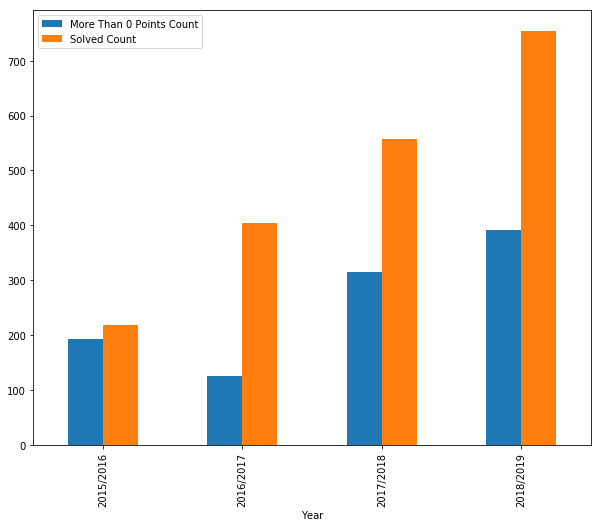

In [7]:
per_module = util.task.points_per_module_all_years().subquery()

per_user = session.query(
    model.Year,
    model.User,
    func.sum(per_module.c.points).label("total_score"),
).\
    join(per_module, model.Year.id == per_module.c.year_id).\
    join(model.User, model.User.id == per_module.c.user_id).\
    filter(model.User.role == 'participant').\
    group_by('year_id', model.User).all()

df = pd.DataFrame(per_user).groupby('Year')
fdf = pd.DataFrame(per_user)
fdf = fdf[fdf['total_score'] > 0].groupby('Year')

per_year = pd.DataFrame({
    'Solved Count': df.total_score.count(),
    'More Than 0 Points Count': fdf.total_score.count(),
})

per_year.plot.bar()

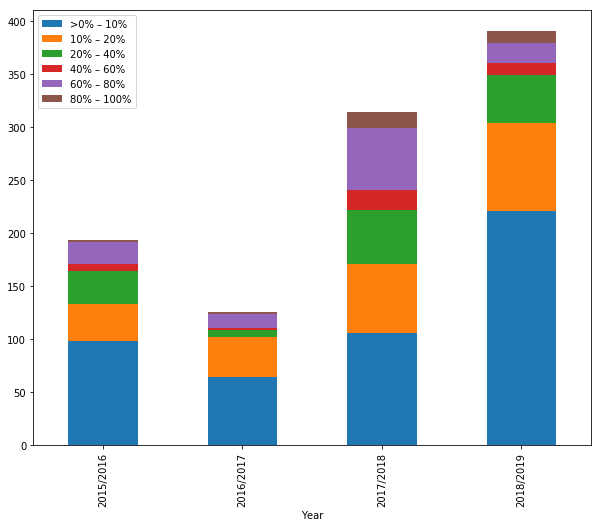

In [8]:
max_points_per_year = util.task.max_points_per_year(bonus=False)

Score = namedtuple('Score', ['Year', 'User', 'RelativePoints'])
relative_per_user = [
    Score(year, user, score / max_points_per_year[year.id][0])
    for year, user, score in per_user
]

fdf = pd.DataFrame(relative_per_user)
fdf = fdf[fdf['RelativePoints'] > 0] # filter 0 points

relative_per_year = pd.DataFrame(OrderedDict((
    ('>0% – 10%', fdf[(fdf['RelativePoints'] >= 0) & (fdf['RelativePoints'] < 0.1)].groupby('Year').RelativePoints.count()),
    ('10% – 20%', fdf[(fdf['RelativePoints'] >= 0.1) & (fdf['RelativePoints'] < 0.2)].groupby('Year').RelativePoints.count()),
    ('20% – 40%', fdf[(fdf['RelativePoints'] >= 0.2) & (fdf['RelativePoints'] < 0.4)].groupby('Year').RelativePoints.count()),
    ('40% – 60%', fdf[(fdf['RelativePoints'] >= 0.4) & (fdf['RelativePoints'] < 0.6)].groupby('Year').RelativePoints.count()),
    ('60% – 80%', fdf[(fdf['RelativePoints'] >= 0.6) & (fdf['RelativePoints'] < 0.8)].groupby('Year').RelativePoints.count()),
    ('80% – 100%', fdf[fdf['RelativePoints'] >= 0.8].groupby('Year').RelativePoints.count()),
)))
relative_per_year.plot.bar(stacked=True)

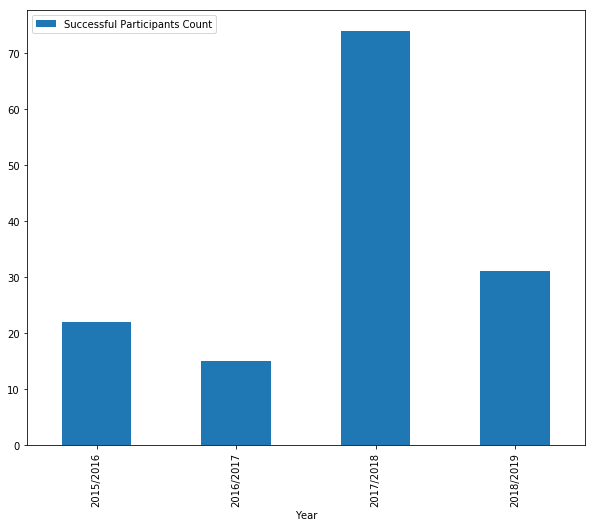

In [9]:
successful_participants = pd.DataFrame({
    'Successful Participants Count': fdf[fdf['RelativePoints'] >= 0.6].groupby('Year').RelativePoints.count(),
})
successful_participants.plot.bar(stacked=True)

In [45]:
tasks_per_year = session.query(
    model.Year,
    func.count(model.Task.id).label('task_count'),
).\
    join(model.Year.tasks).join(model.Task.modules).\
    group_by(model.Year)

big_tasks_per_year = tasks_per_year.\
    filter(model.Module.type == model.ModuleType.GENERAL)

small_tasks_per_year = tasks_per_year.\
    filter(model.Module.type != model.ModuleType.GENERAL)

tasks_per_year_dict = {year: data for (year, data) in tasks_per_year.all()}
big_tasks_per_year_dict = {year: data for (year, data) in big_tasks_per_year.all()}
small_tasks_per_year_dict = {year: data for (year, data) in small_tasks_per_year.all()}

In [66]:
YearData = namedtuple('YearData', [
    'Year', 'small_tasks_count', 'big_tasks_cont'
])

year_data = [
    YearData(
        year,
        small_tasks_per_year_dict[year],
        big_tasks_per_year_dict[year],
    )
    for year in tasks_per_year_dict.keys()
]

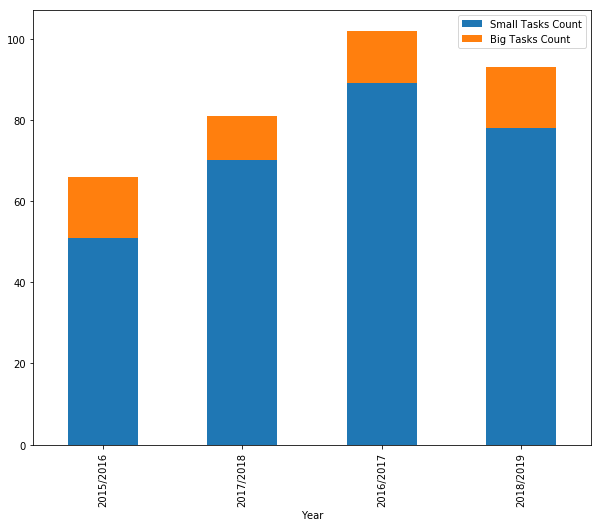

In [64]:
df = pd.DataFrame(year_data, columns=[
    'Year',
    'Small Tasks Count',
    'Big Tasks Count',
]).set_index('Year')

df.plot.bar(stacked=True)

In [75]:
YearData = namedtuple('YearData', [
    'Year', 'tasks_count', 'small_tasks_count', 'big_tasks_cont',
    'big_tasks_ratio'
])

year_data = [
    YearData(
        year,
        tasks_per_year_dict[year],
        small_tasks_per_year_dict[year],
        big_tasks_per_year_dict[year],
        big_tasks_per_year_dict[year] / tasks_per_year_dict[year],
    )
    for year in tasks_per_year_dict.keys()
]

In [80]:
df = pd.DataFrame(year_data, columns=[
    'Year',
    'Tasks Count',
    'Small Tasks Count',
    'Big Tasks Count',
    'Big Tasks Ratio',
]).set_index('Year')

s = df.style
s.format({'Big Tasks Ratio': '{:,.1%}'.format})
s.background_gradient(subset=[
    'Tasks Count',
    'Small Tasks Count',
    'Big Tasks Count',
    'Big Tasks Ratio',
], cmap=sns.light_palette('orange', as_cmap=True))

display(s)

,Tasks Count,Small Tasks Count,Big Tasks Count,Big Tasks Ratio
Year,,,,
2015/2016,66,51,15,22.7%
2017/2018,81,70,11,13.6%
2016/2017,102,89,13,12.7%
2018/2019,93,78,15,16.1%
